
# Reinforcement Learning: FrozenLake Environment

This notebook applies reinforcement learning algorithms to the FrozenLake environment using various approaches, including policy evaluation and control methods. The FrozenLake environment is a 4x4 grid where an agent attempts to navigate to a goal without falling into holes.


In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML

import numpy as np
import pandas as pd
from numpy import linalg as LA
from numpy import genfromtxt
from scipy import stats
import random
import matplotlib.pyplot as plt


In [3]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils

from gym import Env, spaces
from gym.utils import seeding

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "2x2": ["SF", "HG"],
    "4x4-easy":["SFFF", "FHFF", "FFFF", "HFFG"],
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}



def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.random()).argmax()


class DiscreteEnv(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """

    def __init__(self, nS, nA, P, isd, max_length=100, termination_penalty=-50):
        self.P = P
        self.isd = isd
        self.lastaction = None  # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.s = categorical_sample(self.isd, self.np_random)
        self.max_length = max_length
        self.termination_penalty = termination_penalty

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        self.t = 0
        return int(self.s)

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        if self.t >= self.max_length:
            d = True
            r = self.termination_penalty
        self.t += 1
        return (int(s), r, d, {"prob": p})

def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="4x4", slip_rate=0.5):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b"S").astype("float64").ravel()
        isd /= isd.sum()

        P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            # reward = float(newletter == b"G")
            reward = -1
            # if newletter == b"H":
            #     reward = -100
            done = False
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter == b"G":
                        li.append((1.0, s, 0, True))
                    if letter == b'H':
                        li.append((1.0, s, -100, True))
                    else:
                        if slip_rate > 0:
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a - 1) % 4)))
                            li.append((1 - slip_rate, *update_probability_matrix(row, col, a)))
                            li.append((slip_rate/2.0, *update_probability_matrix(row, col, (a + 1) % 4)))
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                "  ({})\n".format(["Left", "Down", "Right", "Up"][self.lastaction])
            )
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

In [4]:
def init_variables():
  rows, cols = (16, 4)
  Q = []
  R = []
  pi = []
  for i in range(rows):
    Q_col = []
    pi_col = []
    R_col = []
    for j in range(cols):
        Q_col.append(0)
        pi_col.append(0)
        R_col.append([0])
    Q.append(Q_col)
    pi.append(pi_col)
    R.append(R_col)
  for i in range(rows):
    pi[i][2] = 1
  return Q, pi, R

def return_average(R):
  sum = 0
  for i in range(16):
    for j in range(4):
      sum += np.mean(R[i][j])
  return sum/16

def plot_many(experiments, label=None, color=None):
  mean_exp = np.mean(experiments, axis=0)
  std_exp = np.std(experiments, axis=0)
  plt.plot(mean_exp, color=color, label=label)
  plt.fill_between(range(len(experiments[0])), mean_exp + std_exp,
      mean_exp - std_exp, color=color, alpha=0.1)

In [5]:
#Q1-1
def generate_episode(pi, env, render):
  next_state = 0
  Terminate = False
  states = []
  rewards = []
  actions = []
  while Terminate == False:
    if render == True:
      env.render()
    states.append(next_state)
    actions.append(np.random.choice(4, 1, p=pi[next_state])[0])
    next_state, reward, done, extra = env.step(actions[-1])
    rewards.append(reward)
    if render == True:
      print(reward)
    if reward != -1:
      Terminate = True
  return states, actions, rewards


SFFF
FHFH
FFFH
HFFG
-1
  (Up)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
0
-58.397


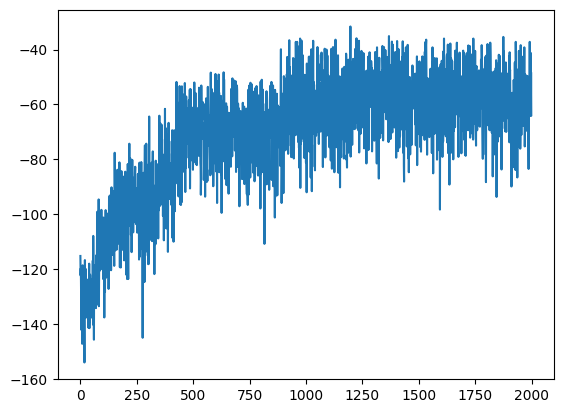

In [6]:
#Q1_2
gamma = 0.99
epsilon = 0.05
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

def mont_carlo(env, render_index):
  Q, pi, R = init_variables()
  Returns = []
  ep_num = 0
  while True:

    if ep_num == 2001:
      break

    initial_state = env.reset()
    visited_steps = []

    if ep_num == 2000 and render_index == 9:
      render = True
    else:
      render = False

    states, actions, rewards = generate_episode(pi, env, render)
    G = 0
    R_undiscounted = 0
    T_state = len(states) - 1
    for i in range(T_state, -1, -1):
      G = gamma*G + rewards[i]
      R_undiscounted += rewards[i]
      if (states[i], actions[i]) in visited_steps:
        continue
      else:
        visited_steps.append((states[i], actions[i]))
        R[states[i]][actions[i]].append(G)
        Q[states[i]][actions[i]] = np.mean(R[states[i]][actions[i]])
        chosen_action = np.argmax(Q[states[i]])
        for j in range(4):
          if j == chosen_action:
            pi[states[i]][j] = 1 - 3*epsilon/4
          else:
            pi[states[i]][j] = epsilon/4

    Returns.append(R_undiscounted)
    ep_num += 1
  return Q, pi, R, Returns

total_R = [0]*2000
pi_t = []
for i in range(10):
  Q, pi, R, Returns = mont_carlo(env, i)
  pi_t.append(pi)
  for j in range(2000):
    total_R[j] += Returns[j]
for i in range(2000):
  total_R[i] = total_R[i]/10
plt.plot(total_R)
print(np.mean(total_R[1900:2000]))

-23.005418821339944
-18.953059438534154
-14.768308401724687
-9.252591988300171


-25.35107321909976
-100.0
-11.790111170611477
-100.0


-10.189101385768792
-7.262471176346032
-3.6932459471886645
-100.0


-100.0
-4.57606767576532
-1.0460396780166756
0.0


-99.99779117277707
-99.61356029081726
-99.52087477409064
-99.95690302416209


-99.99682637132229
-100.0
-99.40588806053641
-100.0


-98.40404577792921
-7.120934275969429
-86.19598953509389
-100.0


-100.0
-3.911113767129759
-1.631778367028046
0.0




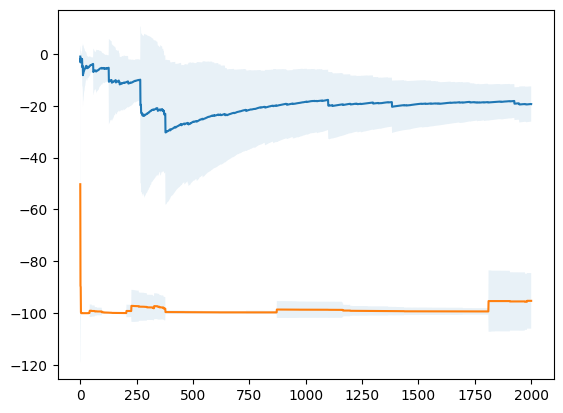

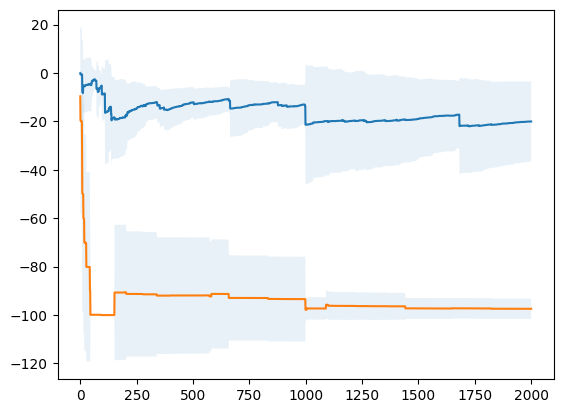

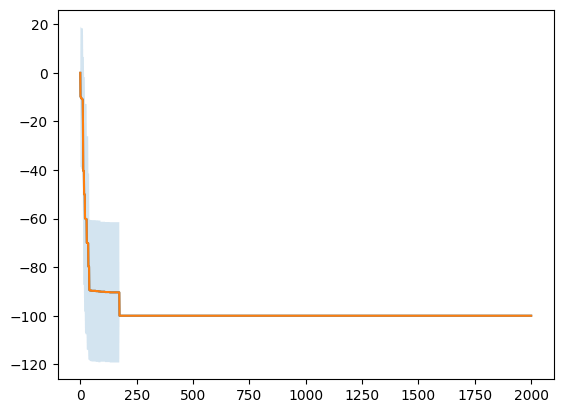

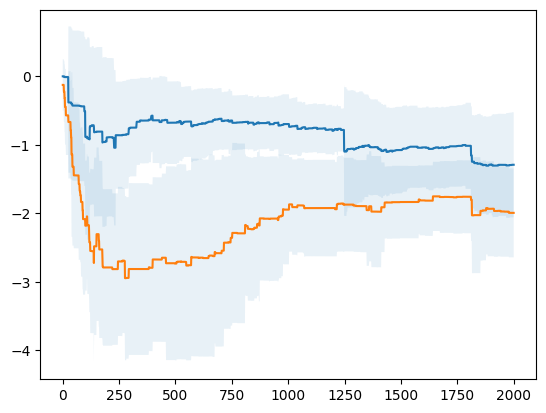

In [28]:
#Q1-3
gamma = 0.99
epsilon = 0.05
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

def mont_carlo_off(pi):
    #initializations
    Q_O, trash, trash1 = init_variables()
    Q_W, trash, trash1 = init_variables()
    C_O, trash, trash1 = init_variables()
    C_W, trash, trash1 = init_variables()
    rows, cols = (16, 4)
    b = []
    for i in range(rows):
      b_col = []
      for j in range(cols):
          b_col.append(0.25)
      b.append(b_col)
    ep_num = 0
    V_0_O = []
    V_3_O = []
    V_7_O = []
    V_14_O = []
    V_0_W = []
    V_3_W = []
    V_7_W = []
    V_14_W = []
    while True:
      if ep_num == 2001:
        break
      initial_state = env.reset()
      render = False
      states, actions, rewards = generate_episode(b, env, render)
      G= 0 
      W = 1
      T_state = len(states) - 1
      for i in range(T_state , -1, -1):
        G = gamma*G + rewards[i]
        C_O[states[i]][actions[i]] += 1
        Q_O[states[i]][actions[i]] += ((W*G) - Q_O[states[i]][actions[i]]) / C_O[states[i]][actions[i]]
        C_W[states[i]][actions[i]] += W
        Q_W[states[i]][actions[i]] += (W/C_W[states[i]][actions[i]])*(G - Q_W[states[i]][actions[i]])
        W = W*(pi[states[i]][actions[i]])/(b[states[i]][actions[i]])
      V_pi_O = [0]*16 
      V_pi_W = [0]*16
      for i in range(16):
        for j in range(4):
          V_pi_O[i] += Q_O[i][j]*pi[i][j]
          V_pi_W[i] += Q_W[i][j]*pi[i][j]
      V_0_O.append(V_pi_O[0])
      V_3_O.append(V_pi_O[3])
      V_7_O.append(V_pi_O[7])
      V_14_O.append(V_pi_O[14])
      V_0_W.append(V_pi_W[0])
      V_3_W.append(V_pi_W[3])
      V_7_W.append(V_pi_W[7])
      V_14_W.append(V_pi_W[14])
      ep_num += 1 
    return V_pi_O, V_pi_W, Q_O, Q_W, V_0_O, V_3_O, V_7_O, V_14_O, V_0_W, V_3_W, V_7_W, V_14_W
      

experiments_O_0 = []
experiments_W_0 = []
experiments_O_3 = []
experiments_W_3 = []
experiments_O_7 = []
experiments_W_7 = []
experiments_O_14 = []
experiments_W_14 = []
for r in range(10):
  V_pi_O, V_pi_W, Q_O, Q_W, V_0_O, V_3_O, V_7_O, V_14_O, V_0_W, V_3_W, V_7_W, V_14_W = mont_carlo_off(pi_t[4])
  experiments_O_0.append(V_0_O)
  experiments_O_3.append(V_3_O)
  experiments_O_7.append(V_7_O)
  experiments_O_14.append(V_14_O)
  experiments_W_0.append(V_0_W)
  experiments_W_3.append(V_3_W)
  experiments_W_7.append(V_7_W)
  experiments_W_14.append(V_14_W)

plt.figure(0)
plot_many(experiments_O_0)
plot_many(experiments_W_0)

plt.figure(1)
plot_many(experiments_O_3)
plot_many(experiments_W_3)

plt.figure(2)
plot_many(experiments_O_7)
plot_many(experiments_W_7)

plt.figure(3)
plot_many(experiments_O_14)
plot_many(experiments_W_14)

index = 0
for j in range(4):
  for i in range(4):
    print(V_pi_O[index])
    index += 1
  print("\n")

index = 0
for j in range(4):
  for i in range(4):
    print(V_pi_W[index])
    index += 1
  print("\n")

In [ ]:

print(pi)

[[0.0125, 0.9625, 0.0125, 0.0125], [0.9625, 0.0125, 0.0125, 0.0125], [0.9625, 0.0125, 0.0125, 0.0125], [0.9625, 0.0125, 0.0125, 0.0125], [0.0125, 0.9625, 0.0125, 0.0125], [0, 0, 1, 0], [0.0125, 0.0125, 0.0125, 0.9625], [0, 0, 1, 0], [0.0125, 0.0125, 0.9625, 0.0125], [0.0125, 0.9625, 0.0125, 0.0125], [0.0125, 0.9625, 0.0125, 0.0125], [0, 0, 1, 0], [0, 0, 1, 0], [0.0125, 0.0125, 0.9625, 0.0125], [0.0125, 0.0125, 0.9625, 0.0125], [0, 0, 1, 0]]


-98.68690723758404
-98.77852783690973
-97.90665854589258
-99.12480200705981
-98.47179576075362
-100.0
-96.13825757794106
-100.0
-96.74599236783648
-91.60197752177884
-87.7320054317321
-100.0
-100.0
-82.85821973746137
-58.079716594447575
0.0


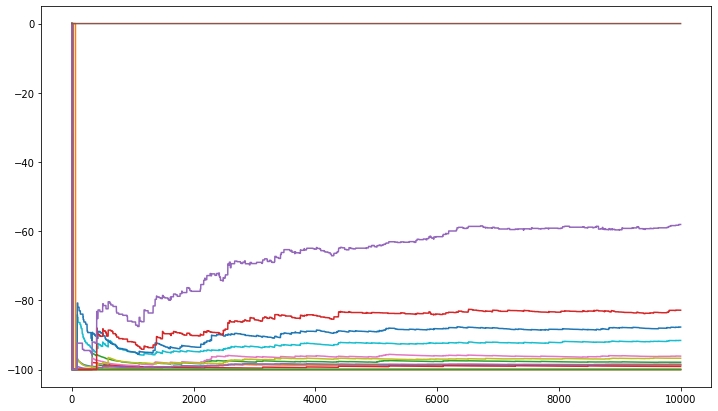

In [58]:
#Q2-1
gamma = 0.99
epsilon = 0.05
env = FrozenLakeEnv(map_name="4x4", slip_rate=0)
def mont_carlo_every_visit(env, render_index):
  rows, cols = (16, 10000)
  V_pi = []
  for i in range(rows):
    V_col = []
    for j in range(cols):
        V_col.append(0)
    V_pi.append(V_col)
  R = [0]*16
  N = [0]*16
  rows, cols = (16, 4)
  pi = []
  for i in range(rows):
    pi_col = []
    for j in range(cols):
        pi_col.append(0.25)
    pi.append(pi_col)
  
  ep_num = 0
  while True:
    if ep_num == 10000:
      break
    initial_state = env.reset()
    states, actions, rewards = generate_episode(pi, env, False)
    if ep_num == 9999:
        render = True
    else:
      render = False

    if ep_num != 0:
      for i in range(16):
        V_pi[i][ep_num] = V_pi[i][ep_num - 1]
    
    G = 0
    T_state = len(states) - 1
    for i in range(T_state , -1, -1):
      G = gamma*G + rewards[i]
      R[states[i]] += G
      N[states[i]] += 1
      V_pi[states[i]][ep_num] = (R[states[i]])/N[states[i]]
    ep_num += 1
  return V_pi


V_pi = mont_carlo_every_visit(env, 0)
plt.figure(figsize=(12,7))
for i in range(16):
  plt.plot(V_pi[i])
  print(V_pi[i][-1])

-98.1828598754604
-98.40694832740328
-97.22516704544476
-98.52951482333216
-98.02179437137332
-100
-94.6250161402302
-100
-95.40105306312499
-88.88957681449723
-82.26659852240877
-100
-100
-79.4062080568347
-48.697952557882886
0.0


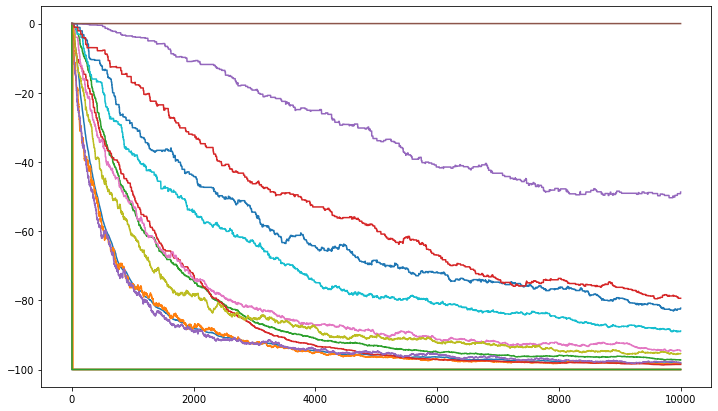

In [98]:
#Q2-2
gamma = 0.99
epsilon = 0.05
alpha = 0.01
env = FrozenLakeEnv(map_name="4x4", slip_rate=0)
def TD_0(env):
  rows, cols = (16, 10000)
  V_pi = []
  for i in range(rows):
    V_col = []
    for j in range(cols):
        V_col.append(0)
    V_pi.append(V_col)

  rows, cols = (16, 4)
  pi = []
  for i in range(rows):
    pi_col = []
    for j in range(cols):
        pi_col.append(0.25)
    pi.append(pi_col)

  ep_num = 0
  while True:
    if ep_num == 10000:
      break

    initial_state = env.reset()
    current_state = 0

    if ep_num != 0:
      for i in range(16):
        V_pi[i][ep_num] = V_pi[i][ep_num - 1]

    while True:
      action = np.random.choice(4, 1, p=pi[current_state])[0]
      next_state, reward, done, extra = env.step(action)
      if next_state == 5 or next_state == 7 or next_state == 11 or next_state == 12:
        V_pi[current_state][ep_num] += alpha*(reward + gamma*V_pi[next_state][ep_num] - V_pi[current_state][ep_num])
        V_pi[next_state][ep_num] = -100
        break
        
      V_pi[current_state][ep_num] += alpha*(reward + gamma*V_pi[next_state][ep_num] - V_pi[current_state][ep_num])

      #if ep_num == 9999:
        #env.render()
      current_state = next_state

      

      if reward != -1:
        break

    ep_num += 1
  return V_pi


V_pi = TD_0(env)
plt.figure(figsize=(12,7))
for i in range(16):
  plt.plot(V_pi[i])
  print(V_pi[i][-1])

-99.90962434052737
-99.6008230933105
-99.19588828629331
-99.63661317950069
-99.11567441877624
-99.99999999999929
-96.92883563838153
-99.99879534049559
-97.02193491023039
-90.25677388794018
-88.57264852702842
-90.48003096407825
-99.99992328017011
-82.48473848147574
-61.42038265785796
0.0


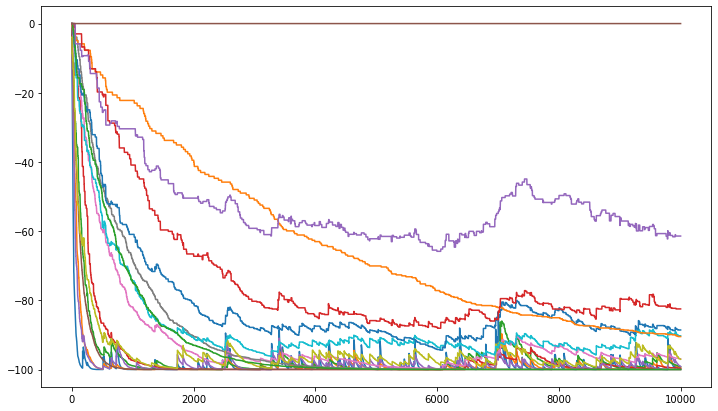

In [104]:
#Q2-3&4
gamma = 0.99
epsilon = 0.05
alpha = 0.01
env = FrozenLakeEnv(map_name="4x4", slip_rate=0)
def TD_n(env, n):
  rows, cols = (16, 10000)
  V_pi = []
  for i in range(rows):
    V_col = []
    for j in range(cols):
        V_col.append(0)
    V_pi.append(V_col)

  rows, cols = (16, 4)
  pi = []
  for i in range(rows):
    pi_col = []
    for j in range(cols):
        pi_col.append(0.25)
    pi.append(pi_col)

  ep_num = 0
  while True:
    if ep_num >= 10000:
      break
    S = []
    R = []
    initial_state = env.reset()
    if ep_num != 0:
      for j in range(16):
        V_pi[j][ep_num] = V_pi[j][ep_num - 1]
    current_state = 0
    S.append(current_state)
    R.append(-1)
    T = float('inf')
    t = 0
    visit = [0]*16

    while True:
      if t < T:
        action = np.random.choice(4, 1, p=pi[S[-1]])[0]
        next_state, reward, done, extra = env.step(action)
        S.append(next_state)
        R.append(reward)
        if reward != -1:
          T = t + 1
        visit[S[-1]] += 1
      tau = t - n + 1
      
      if tau >= 0:
        G = 0
        for i in range(tau + 1,min(tau + n, T) + 1):
          G += (gamma**(i - tau - 1))*R[i]
        if tau + n < T:
          G += (gamma**n)*V_pi[S[tau+n]][ep_num]
        V_pi[S[tau]][ep_num] += alpha*(G - V_pi[S[tau]][ep_num]) 
        
      if tau == T-1:
        break
      t += 1


    ep_num += 1
  return V_pi


V_pi = TD_n(env, 100)
for i in range(16):
  print(V_pi[i][-1])
plt.figure(figsize=(12,7))
for i in range(16):
  plt.plot(V_pi[i])


-98.85112106888869
-98.9791479694465
-98.2926586400813
-98.72146227075399
-98.21440318919436
-99.33283372750587
-96.54585077312005
-98.31735069616784
-96.14833520826761
-90.15449711084153
-85.31276877436822
-96.24082511867842
-98.46574847057343
-81.92663468987594
-53.831234645361526
0.0


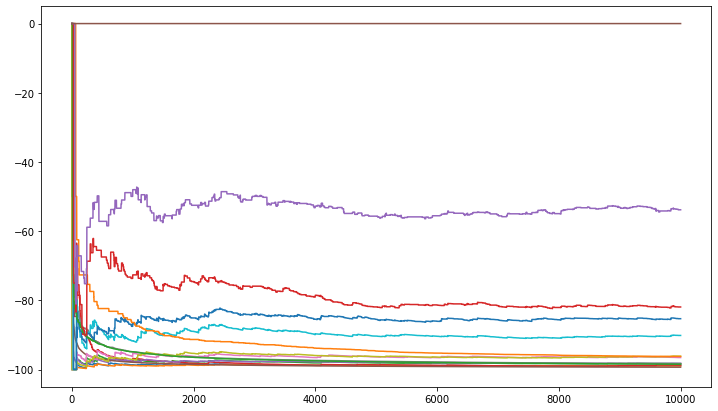

In [102]:
#Q2-5
gamma = 0.99
epsilon = 0.05
alpha = 0.01
env = FrozenLakeEnv(map_name="4x4", slip_rate=0)
def TD_n(env, n):
  rows, cols = (16, 10000)
  V_pi = []
  for i in range(rows):
    V_col = []
    for j in range(cols):
        V_col.append(0)
    V_pi.append(V_col)

  rows, cols = (16, 4)
  pi = []
  for i in range(rows):
    pi_col = []
    for j in range(cols):
        pi_col.append(0.25)
    pi.append(pi_col)
  visit = [0]*16

  ep_num = 0
  while True:
    if ep_num >= 10000:
      break
    S = []
    R = []
    initial_state = env.reset()
    if ep_num != 0:
      for j in range(16):
        V_pi[j][ep_num] = V_pi[j][ep_num - 1]
    current_state = 0
    S.append(current_state)
    R.append(-1)
    T = float('inf')
    t = 0

    while True:
      if t < T:
        action = np.random.choice(4, 1, p=pi[S[-1]])[0]
        next_state, reward, done, extra = env.step(action)
        
        S.append(next_state)
        R.append(reward)
        if reward != -1:
          T = t + 1
        visit[S[-1]] += 1
      tau = t - n + 1
      
      if tau >= 0:
        G = 0
        for i in range(tau + 1,min(tau + n, T) + 1):
          G += (gamma**(i - tau - 1))*R[i]
        if tau + n < T:
          G += (gamma**n)*V_pi[S[tau+n]][ep_num]
        if visit[S[tau]] != 0:
          alpha = 1/visit[S[tau]]
        else:
          alpha = 0
        V_pi[S[tau]][ep_num] += alpha*(G - V_pi[S[tau]][ep_num]) 
        
      if tau == T-1:
        break
      t += 1


    ep_num += 1
  return V_pi


V_pi = TD_n(env, 100)
for i in range(16):
  print(V_pi[i][-1])
plt.figure(figsize=(12,7))
for i in range(16):
  plt.plot(V_pi[i])



### Finding the Next Action Using Policy

This cell defines a function `find_next_action`, which selects the next action to take based on the current policy and Q-values. It is a helper function for choosing the best possible action by exploring the Q-table.


In [106]:
def find_next_action(Q, s):
  pi = [0]*4
  for i in range(4):
    if i == np.argmax(Q[s]):
      pi[i] = 1 - epsilon + epsilon/4
    else:
      pi[i] =epsilon/4
  return np.random.choice(4, 1, p=pi)[0], pi


### Finding the Next Action Using Policy

This cell defines a function `find_next_action`, which selects the next action to take based on the current policy and Q-values. It is a helper function for choosing the best possible action by exploring the Q-table.


  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Left)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Left)
SFFF
FHFH
FFFH
HFFG
0


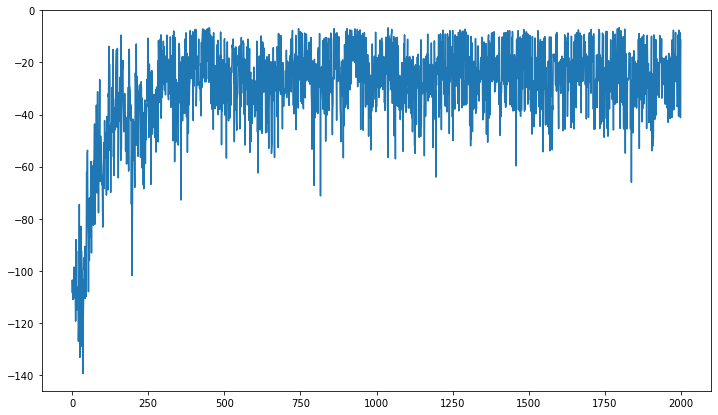

In [108]:
#Q3-1
gamma = 0.99
epsilon = 0.01
alpha = 0.1
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

def SARSA(env, render_num):
  rows, cols = (16, 4)
  Q = []
  for i in range(rows):
    Q_col = []
    for j in range(cols):
        Q_col.append(0)
    Q.append(Q_col)
  R = []
  ep_num = 0
  while ep_num != 2000:
    initial_state = env.reset()
    current_state = 0
    action, pi = find_next_action(Q, current_state)
    R.append(0)
    reward = -1
    while reward == -1:
      next_state, reward, done, extra = env.step(action)
      if ep_num == 1999 and render_num == True:
        env.render()
        print(reward)
      if next_state == 5 or next_state == 7 or next_state == 11 or next_state == 12:
          reward = -100
      R[-1] += reward
      next_action, pi = find_next_action(Q,next_state)
      Q[current_state][action] += alpha*(reward + gamma*Q[next_state][next_action] - Q[current_state][action])
      current_state = next_state
      action = next_action
    ep_num += 1
  return R, Q

random.seed(0)
R0, Q0 = SARSA(env, False)
random.seed(1)
R1, Q1 = SARSA(env, False)
random.seed(2)
R2, Q2 = SARSA(env, False)
random.seed(3)
R3, Q3 = SARSA(env, False)
random.seed(4)
R4, Q4 = SARSA(env, True)
random.seed(5)
R5, Q5 = SARSA(env, False)
random.seed(6)
R6, Q6 = SARSA(env, False)
random.seed(7)
R7, Q7 = SARSA(env, False)
random.seed(8)
R8, Q8 = SARSA(env, False)
random.seed(9)
R9, Q9 = SARSA(env, False)

def sum_lists(*args):
    return list(map(sum, zip(*args)))
R = sum_lists(R0, R1, R2, R3, R4, R5, R6, R7, R8, R9)
for i in range(2000):
  R[i] /= 10
plt.figure(figsize=(12,7))
plt.plot(R)



### Finding the Next Action Using Policy

This cell defines a function `find_next_action`, which selects the next action to take based on the current policy and Q-values. It is a helper function for choosing the best possible action by exploring the Q-table.


  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1


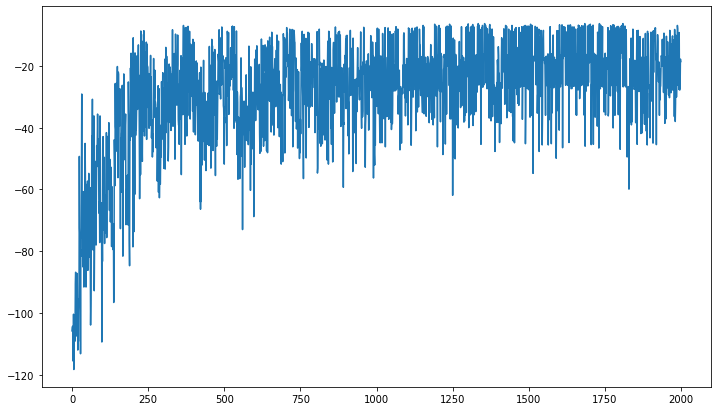

In [109]:
#Q3-2
gamma = 0.99
epsilon = 0.01
alpha = 0.1
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

def SARSA(env, render_num):
  rows, cols = (16, 4)
  Q = []
  for i in range(rows):
    Q_col = []
    for j in range(cols):
        Q_col.append(0)
    Q.append(Q_col)
  R = []
  ep_num = 0
  while ep_num != 2000:
    initial_state = env.reset()
    current_state = 0
    R.append(0)
    reward = -1
    while reward == -1:
      action, pi = find_next_action(Q, current_state)
      next_state, reward, done, extra = env.step(action)
      if ep_num == 1999 and render_num == True:
        env.render()
        print(reward)
      if next_state == 5 or next_state == 7 or next_state == 11 or next_state == 12:
          reward = -100
      R[-1] += reward
      Q_total = 0
      a, pi = find_next_action(Q, next_state)
      for i in range(4):
        Q_total += Q[next_state][i]*pi[i]
      Q[current_state][action] += alpha*(reward + gamma*Q_total - Q[current_state][action])
      current_state = next_state
    ep_num += 1
  return R, Q

random.seed(0)
R0, Q0 = SARSA(env, False)
random.seed(1)
R1, Q1 = SARSA(env, False)
random.seed(2)
R2, Q2 = SARSA(env, False)
random.seed(3)
R3, Q3 = SARSA(env, False)
random.seed(4)
R4, Q4 = SARSA(env, True)
random.seed(5)
R5, Q5 = SARSA(env, False)
random.seed(6)
R6, Q6 = SARSA(env, False)
random.seed(7)
R7, Q7 = SARSA(env, False)
random.seed(8)
R8, Q8 = SARSA(env, False)
random.seed(9)
R9, Q9 = SARSA(env, False)

def sum_lists(*args):
    return list(map(sum, zip(*args)))
R = sum_lists(R0, R1, R2, R3, R4, R5, R6, R7, R8, R9)
for i in range(2000):
  R[i] /= 10
plt.figure(figsize=(12,7))
plt.plot(R)



### Finding the Next Action Using Policy

This cell defines a function `find_next_action`, which selects the next action to take based on the current policy and Q-values. It is a helper function for choosing the best possible action by exploring the Q-table.


  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Down)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Right)
SFFF
FHFH
FFFH
HFFG
-1
  (Left)
SFFF
FHFH
FFFH
HFFG
0


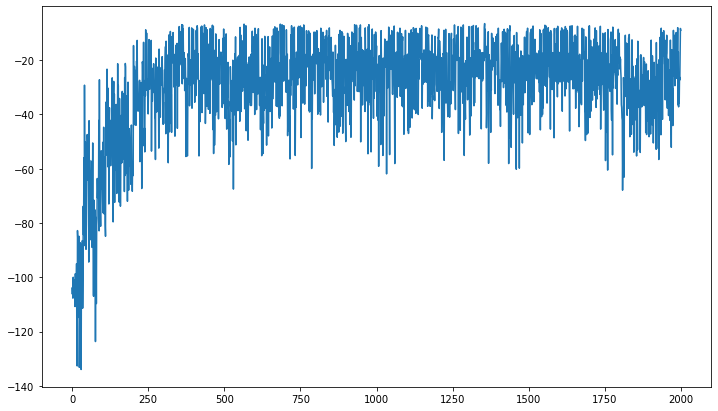

In [111]:
#Q3-3
gamma = 0.99
epsilon = 0.01
alpha = 0.1
env = FrozenLakeEnv(map_name="4x4", slip_rate=0.1)

def SARSA(env, render_num):
  rows, cols = (16, 4)
  Q = []
  for i in range(rows):
    Q_col = []
    for j in range(cols):
        Q_col.append(0)
    Q.append(Q_col)
  R = []
  ep_num = 0
  while ep_num != 2000:
    initial_state = env.reset()
    current_state = 0
    R.append(0)
    reward = -1
    while reward == -1:
      action, pi = find_next_action(Q, current_state)
      next_state, reward, done, extra = env.step(action)
      if ep_num == 1999 and render_num == True:
        env.render()
        print(reward)
      if next_state == 5 or next_state == 7 or next_state == 11 or next_state == 12:
          reward = -100
      R[-1] += reward
      Q[current_state][action] += alpha*(reward + gamma*Q[next_state][np.argmax(Q[next_state])] - Q[current_state][action])
      current_state = next_state
    ep_num += 1
  return R, Q

random.seed(0)
R0, Q0 = SARSA(env, False)
random.seed(1)
R1, Q1 = SARSA(env, False)
random.seed(2)
R2, Q2 = SARSA(env, False)
random.seed(3)
R3, Q3 = SARSA(env, False)
random.seed(4)
R4, Q4 = SARSA(env, True)
random.seed(5)
R5, Q5 = SARSA(env, False)
random.seed(6)
R6, Q6 = SARSA(env, False)
random.seed(7)
R7, Q7 = SARSA(env, False)
random.seed(8)
R8, Q8 = SARSA(env, False)
random.seed(9)
R9, Q9 = SARSA(env, False)

def sum_lists(*args):
    return list(map(sum, zip(*args)))
R = sum_lists(R0, R1, R2, R3, R4, R5, R6, R7, R8, R9)
for i in range(2000):
  R[i] /= 10
plt.figure(figsize=(12,7))
plt.plot(R)
